<a href="https://colab.research.google.com/github/Altemir1/Crypto-DL-Based-Trading-System/blob/main/sentiment_analysis_on_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Collection

Import dataset from the hugging face datasets

In [2]:
import pandas as pd

df = pd.read_csv("hf://datasets/edaschau/bitcoin_news/BTC_yahoo.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df.head()

,time_unix,date_time,text_matches,title_matches,title,url,source,source_url,article_text
0,1308740160,2011-06-22 10:56:00+00:00,"{""Bitcoin"": [0, 967, 1184, 1227]}","{""Bitcoin"": [37]}",Compromised account leads to massive Bitcoin s...,https://finance.yahoo.com/news/2011-06-22-comp...,Engadget,https://www.engadget.com/,"Bitcoin, for those not aware, is a completely ..."
1,1328119352,2012-02-01 18:02:32+00:00,"{""Bitcoin"": [18, 195, 1871, 2827, 3683]}","{""Bitcoin"": [0]}",Bitcoin May Be The Currency Of The Future,https://finance.yahoo.com/news/bitcoin-may-cur...,Investopedia,http://www.investopedia.com/,Have you heard of Bitcoin? If you're a fan of ...
2,1332444236,2012-03-22 19:23:56+00:00,"{""Bitcoin"": [562, 705, 981, 1064, 2068, 2221, ...","{""Bitcoin"": [56]}",Should Africa Adopt a Shared Currency? And Sho...,https://finance.yahoo.com/news/africa-adopt-sh...,The Atlantic,http://www.theatlantic.com/,Dekstop /Flickr I wrote on Monday about Sweden...
3,1345679880,2012-08-22 23:58:00+00:00,"{""Bitcoin"": [450]}",{},"MasterCard denies BitCoin card rumors, BitInst...",https://finance.yahoo.com/news/2012-08-22-mast...,Engadget,https://www.engadget.com/,MasterCard shoots down BitCoin debit card rumo...
4,1347025081,2012-09-07 13:38:01+00:00,"{""Bitcoin"": [1231, 5352]}",{},Claim of Romney taxes theft a puzzling whodunit,https://finance.yahoo.com/news/claim-romney-ta...,Associated Press,https://apnews.com/,"WASHINGTON (AP) — Assuming it's not a hoax, th..."


In [4]:
df_selected_features = df[["date_time", "title", "source"]]
df_selected_features.head()

,date_time,title,source
0,2011-06-22 10:56:00+00:00,Compromised account leads to massive Bitcoin s...,Engadget
1,2012-02-01 18:02:32+00:00,Bitcoin May Be The Currency Of The Future,Investopedia
2,2012-03-22 19:23:56+00:00,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic
3,2012-08-22 23:58:00+00:00,"MasterCard denies BitCoin card rumors, BitInst...",Engadget
4,2012-09-07 13:38:01+00:00,Claim of Romney taxes theft a puzzling whodunit,Associated Press


In [5]:
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80806 entries, 0 to 80805
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_time  80806 non-null  object
 1   title      80806 non-null  object
 2   source     80806 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [6]:
btc_news = df_selected_features.copy()

In [7]:
split_df = btc_news["date_time"].str.split(" ")
btc_news["date"] = split_df.str[0]
btc_news["time"] = split_df.str[1]

btc_news.head()

,date_time,title,source,date,time
0,2011-06-22 10:56:00+00:00,Compromised account leads to massive Bitcoin s...,Engadget,2011-06-22,10:56:00+00:00
1,2012-02-01 18:02:32+00:00,Bitcoin May Be The Currency Of The Future,Investopedia,2012-02-01,18:02:32+00:00
2,2012-03-22 19:23:56+00:00,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic,2012-03-22,19:23:56+00:00
3,2012-08-22 23:58:00+00:00,"MasterCard denies BitCoin card rumors, BitInst...",Engadget,2012-08-22,23:58:00+00:00
4,2012-09-07 13:38:01+00:00,Claim of Romney taxes theft a puzzling whodunit,Associated Press,2012-09-07,13:38:01+00:00


In [8]:
btc_news["date"] = pd.to_datetime(btc_news["date"], format="%Y-%m-%d")
btc_news["date"]

,date
0,2011-06-22
1,2012-02-01
2,2012-03-22
3,2012-08-22
4,2012-09-07
...,...
80801,2024-01-24
80802,2024-01-24
80803,2024-01-24
80804,2024-01-24


In [9]:
btc_news.drop(columns=["time", "date_time"], inplace=True)

Assigning sentiment score to the article titles

In [10]:
!pip install transformers

Importing necessary libraries

In [11]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import torch

Check if GPU available

In [12]:
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")


Using device: GPU


In [13]:
# Load the FinBERT model with GPU support
model_name = "ProsusAI/finbert"
finbert_pipeline = pipeline("sentiment-analysis", model=model_name, batch_size=64, device=device)  # Increased batch_size

# Convert titles to a list for batch processing
titles = btc_news['title'].tolist()

# Define batch size (Increase for faster processing if GPU memory allows)
batch_size = 64

# Store results
results = []

# Process in batches
for i in tqdm(range(0, len(titles), batch_size), desc="Processing Batches with GPU"):
    batch = titles[i:i+batch_size]
    try:
        result_batch = finbert_pipeline(batch)
        results.extend(result_batch)
    except Exception as e:
        print(f"Error processing batch {i} to {i+batch_size}: {str(e)}")
        results.extend([{'label': None, 'score': None}] * len(batch))

# Convert results to DataFrame columns
btc_news['finbert_sentiment'] = [r['label'] if r else None for r in results]
btc_news['finbert_score'] = [r['score'] if r else None for r in results]

# Save the updated DataFrame to a new CSV file
btc_news.to_csv('bitcoin_articles_with_finbert_sentiment.csv', index=False)

print("Processing completed successfully!")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0

Processing Batches with GPU:   1%|          | 10/1263 [00:02<03:19,  6.28it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

Processing Batches with GPU: 100%|██████████| 1263/1263 [02:46<00:00,  7.57it/s]


Processing completed successfully!


In [14]:
btc_news.head()

,title,source,date,finbert_sentiment,finbert_score
0,Compromised account leads to massive Bitcoin s...,Engadget,2011-06-22,negative,0.801531
1,Bitcoin May Be The Currency Of The Future,Investopedia,2012-02-01,neutral,0.899791
2,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic,2012-03-22,neutral,0.919918
3,"MasterCard denies BitCoin card rumors, BitInst...",Engadget,2012-08-22,neutral,0.906358
4,Claim of Romney taxes theft a puzzling whodunit,Associated Press,2012-09-07,neutral,0.567120


In [16]:
btc_news.finbert_sentiment.value_counts()

,count
finbert_sentiment,
neutral,45883
negative,18445
positive,16478


In [17]:
btc_news.source.value_counts()

,count
source,
CoinDesk,13393
FX Empire,8021
Motley Fool,5646
Reuters,5376
InvestorPlace,3970
...,...
WHIO,1
Guitar World,1
WPXI,1


## EDA

In [2]:
import pandas as pd

df = pd.read_csv("/content/bitcoin_articles_with_finbert_sentiment.csv")
df.head()

,title,source,date,finbert_sentiment,finbert_score
0,Compromised account leads to massive Bitcoin s...,Engadget,2011-06-22,negative,0.801531
1,Bitcoin May Be The Currency Of The Future,Investopedia,2012-02-01,neutral,0.899791
2,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic,2012-03-22,neutral,0.919918
3,"MasterCard denies BitCoin card rumors, BitInst...",Engadget,2012-08-22,neutral,0.906358
4,Claim of Romney taxes theft a puzzling whodunit,Associated Press,2012-09-07,neutral,0.567120


#### Proprotion of publisher on bitcoin

In [3]:
articles_df = df["source"].value_counts()
percentage = (articles_df / articles_df.sum()) * 100

In [4]:
def group_articles(row, percentage):
  if percentage[row["source"]] < 3:
    return "Other"
  else:
    return row["source"]

grouped_articles = df.apply(lambda row: group_articles(row, percentage), axis=1)
grouped_articles.value_counts()

,count
Other,32648
CoinDesk,13393
FX Empire,8021
Motley Fool,5646
Reuters,5376
InvestorPlace,3970
GlobeNewswire,3578
Business Insider,2955
Benzinga,2703
CCN,2516


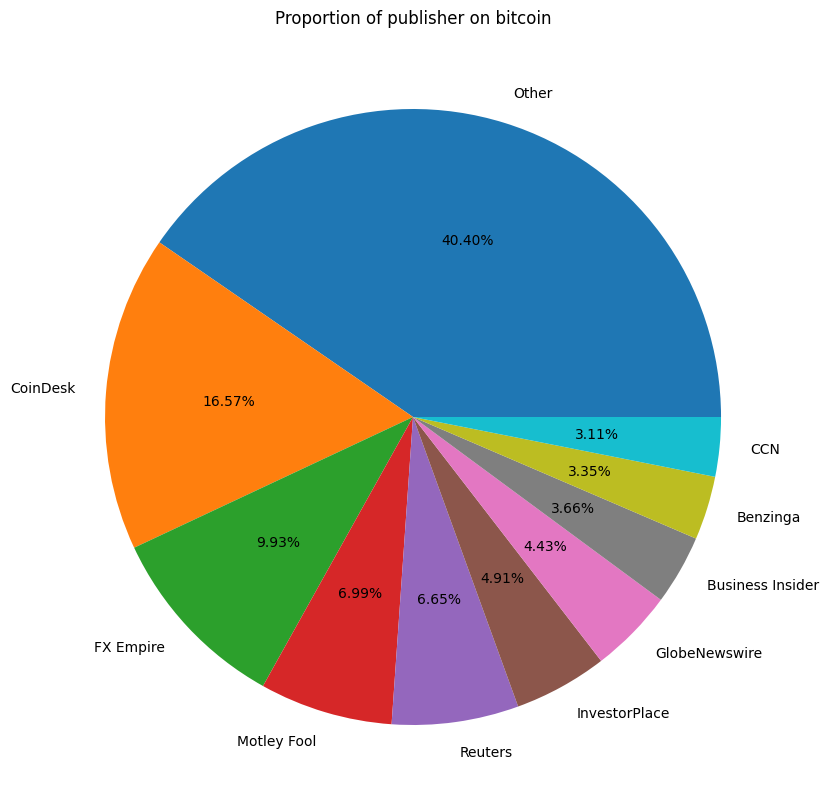

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

visualize_articles = grouped_articles.value_counts()
plt.figure(figsize =(20, 10))
plt.pie(visualize_articles, labels = visualize_articles.index, autopct = "%.2f%%")
plt.title("Proportion of publisher on bitcoin")
plt.show()



#### Prorortion of the news according to the months by sentiment

In [10]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["date"]

,date
0,2011-06-22
1,2012-02-01
2,2012-03-22
3,2012-08-22
4,2012-09-07
...,...
80801,2024-01-24
80802,2024-01-24
80803,2024-01-24
80804,2024-01-24


In [12]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
group_by_year = df.groupby(["year", "month", "finbert_sentiment"]).size().reset_index(name="count")
group_by_year

,year,month,finbert_sentiment,count
0,2011,6,negative,1
1,2012,2,neutral,1
2,2012,3,neutral,1
3,2012,8,neutral,1
4,2012,9,neutral,2
...,...,...,...,...
396,2023,12,neutral,324
397,2023,12,positive,185
398,2024,1,negative,450
399,2024,1,neutral,638


In [25]:
group_by_year['month_total'] = group_by_year.groupby(['year', 'month'])['count'].transform('sum')
group_by_year['proportion'] = group_by_year['count'] / group_by_year['month_total']

In [14]:
btc = pd.read_csv("BTC.csv")
btc.head()

,date,ticker,open,high,low,close,volume
0,2010-07-14,BTC,0.058157,0.061588,0.048647,0.056402,261.54
1,2010-07-15,BTC,0.056403,0.067954,0.053969,0.057568,445.80
2,2010-07-16,BTC,0.058001,0.072220,0.057484,0.066492,497.25
3,2010-07-17,BTC,0.066500,0.077735,0.057418,0.065993,19.99
4,2010-07-18,BTC,0.066088,0.080858,0.064221,0.078814,75.13


In [15]:
btc["date"] = pd.to_datetime(btc["date"])

In [16]:
btc = btc.sort_values(by="date")

In [19]:
btc["year"] = btc["date"].dt.year
btc["month"] = btc["date"].dt.month

In [21]:
monthly_change = btc.groupby(['year', 'month'])['close'].agg(['first', 'last']).reset_index()
monthly_change['percent_change'] = ((monthly_change['last'] - monthly_change['first']) / monthly_change['first']) * 100

In [22]:
monthly_change

,year,month,first,last,percent_change
0,2010,7,0.056402,0.069759,23.681168
1,2010,8,0.060465,0.068038,12.525180
2,2010,9,0.062748,0.061866,-1.406180
3,2010,10,0.060423,0.191777,217.392334
4,2010,11,0.196296,0.215672,9.871050
...,...,...,...,...,...
173,2024,12,97279.792922,93429.202811,-3.958263
174,2025,1,94419.757505,102405.027084,8.457202
175,2025,2,100655.905651,84373.010330,-16.176791
176,2025,3,86031.912398,82548.910961,-4.048499


In [24]:
years = df["year"].unique()
years

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024], dtype=int32)

In [ ]:
for year in years[0]:
  # Taking sample of btc prices according to the year
  btc_sample = btc[btc["year"] == year]

  # Pivotting table with proportion of sentiments
  pivot = group_by_year[group_by_year['year'] == year].pivot(
      index='month',
      columns='finbert_sentiment',
      values='proportion').fillna(0)

  months = pivot.index.tolist()
  negative_vals = pivot['negative'].tolist()
  neutral_vals = pivot['neutral'].tolist()
  positive_vals = pivot['positive'].tolist()

  # Creating 2 plots with price change and proporiton of sentiments
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 12))

  # Price change bar plot
  dynamic_color_list = ["green" if x > 0 else "red" for x in monthly_change["percent_change"]]
  ax1.bar(months, monthly_change["percent_change"], color=dynamic_color_list)
